In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import random

# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\ShankRam\miniconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


cuda:0


In [145]:
input_size  = 28*28   # images are 28x28 pixels
rep_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
classNames = [i for i in range(0,100)]

## Adding some noise and displaying images

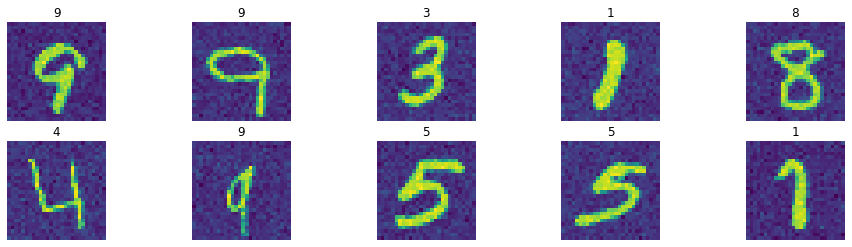

In [146]:
# show some training images with some noise
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(numpy.transpose(npimg, (1, 2, 0))) 
    
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(10):
    image = image_batch[i]
    image = image + torch.randn_like(image)*0.2
    label = label_batch[i]
    plt.subplot(2, 5, i + 1)
    imshow(image,plt)
    plt.axis('off')
    plt.title(classNames[label])

In [147]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data = data.to(device) 
        noisy_data = data + torch.randn_like(data)*0.2
        optimizer.zero_grad()
        output = model(noisy_data)
        loss = F.mse_loss(data.view(-1, 784), output.cuda())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    for data, target in test_loader:
        # send to device
        data = data.to(device)        
        output = model(data)
        test_loss += F.mse_loss(output.cuda(), data.view(-1,784), reduction="mean").item() # sum up batch loss
    test_loss /= len(test_loader.dataset)
    print("Test loss is : ",test_loss,"\n")

In [148]:
class autoenc(nn.Module):
    def __init__(self, size, rep_size):
        super(autoenc, self).__init__()
        self.size = size
        self.network = nn.Sequential(
            nn.Linear(size, rep_size),
            nn.Sigmoid(),
            nn.Linear(rep_size, size),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x = x.view(-1, self.size)
        return self.network(x)

In [167]:
class autoenc_tanh(nn.Module):
    def __init__(self, size, rep_size):
        super(autoenc_tanh, self).__init__()
        self.size = size
        self.network = nn.Sequential(
            nn.Linear(size, rep_size),
            nn.Sigmoid(),
            nn.Linear(rep_size, size),
            nn.Tanh()
            )
        
    def forward(self, x):
        x = x.view(-1, self.size)
        return self.network(x)

In [168]:
print("Training on ", device)
model_fnn = autoenc_tanh(input_size, rep_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.99)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 5):
    train(epoch, model_fnn.cuda())
    test(model_fnn)

Training on  cuda:0
Number of parameters: 157684
Train Epoch: 0 [0/60000 (0%)]	Loss: 1.044794
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.677296
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.693469
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.557256
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.574629
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.561799
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.592772
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.562618
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.558804
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.553019
Test loss is :  0.004135794416069985 

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.506776
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.512832
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.529208
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.473017
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.507798
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.497144
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.513123
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.482388
Train Epoch: 1 [51200/60

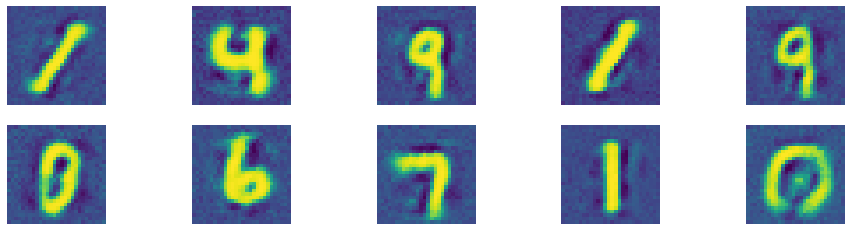

In [169]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(16, 4))

with torch.no_grad():
    for i in range(10):
        image = image_batch[i]
        image = model_fnn(image.cuda()).cpu()
        image = torch.reshape(image, (1,28,28))
        plt.subplot(2, 5, i + 1)
        imshow(image,plt)
        plt.axis('off')

## tanh working much better than sigmoid! lr = 0.99 seems to be slightly worse than 0.9 but no noticeable effect in the output. Shouldn't tanh be a bad choice? The features are pixel intensities; wouldn't a -0.5 be interpreted as ~255 or something?